In [2]:
from gerrychain import Graph

In [3]:
# Read Oklahoma county graph from the json file "OK_county.json"
filepath = 'C:\\districting-data\\'
filename = 'OK_county.json'

# GerryChain has a built-in function for reading graphs of this type:
G = Graph.from_json( filepath + filename )

In [4]:
# Let's impose a 1% population deviation (+/- 0.5%)
deviation = 0.01

import math
k = 5          # number of districts
total_population = sum(G.nodes[node]['TOTPOP'] for node in G.nodes)

L = math.ceil((1-deviation/2)*total_population/k)
U = math.floor((1+deviation/2)*total_population/k)
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 746519 and U = 754021 and k = 5


In [5]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create variables
x = m.addVars(G.nodes, k, vtype=GRB.BINARY) # x[i,j] equals one when county i is assigned to district j
y = m.addVars(G.edges, vtype=GRB.BINARY)  # y[u,v] equals one when edge {u,v} is cut

Academic license - for non-commercial use only - expires 2021-04-22
Using license file C:\Users\buchanan\gurobi.lic


In [6]:
# objective is to minimize cut edges
m.setObjective( gp.quicksum( y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

In [7]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum(x[i,j] for j in range(k)) == 1 for i in G.nodes)

# add constraints saying that each district has population at least L and at most U
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k) )

# add constraints saying that edge {i,j} is cut if i is assigned to district v but j is not.
m.addConstrs( x[i,v] - x[j,v] <= y[i,j] for i,j in G.edges for v in range(k))

{(0, 66, 0): <gurobi.Constr *Awaiting Model Update*>,
 (0, 66, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 66, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 66, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 66, 4): <gurobi.Constr *Awaiting Model Update*>,
 (0, 57, 0): <gurobi.Constr *Awaiting Model Update*>,
 (0, 57, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 57, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 57, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 57, 4): <gurobi.Constr *Awaiting Model Update*>,
 (0, 61, 0): <gurobi.Constr *Awaiting Model Update*>,
 (0, 61, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 61, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 61, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 61, 4): <gurobi.Constr *Awaiting Model Update*>,
 (0, 73, 0): <gurobi.Constr *Awaiting Model Update*>,
 (0, 73, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 73, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 73, 3): <gurobi.Constr 

In [9]:
# Now, let's add contiguity constraints and re-solve the model.
# We will use the contiguity constraints of Hojny et al. (MPC, 2021)
#   https://link.springer.com/article/10.1007/s12532-020-00186-3

# Add root variables: r[i,j] equals 1 if node i is the "root" of district j
r = m.addVars(G.nodes, k, vtype=GRB.BINARY)

# Add flow variables: f[u,v] = amount of flow sent across arc uv 
#  Flows are sent across arcs of the directed version of G which we call DG
import networkx as nx
DG = nx.DiGraph(G) # directed version of G
f = m.addVars(DG.edges, vtype=GRB.CONTINUOUS)

In [10]:
# The big-M proposed by Hojny et al.
M = G.number_of_nodes() - k + 1

# Each district j should have one root
m.addConstrs( gp.quicksum( r[i,j] for i in DG.nodes) == 1 for j in range(k) )

# If node i is not assigned to district j, then it cannot be its root
m.addConstrs( r[i,j] <= x[i,j] for i in DG.nodes for j in range(k) )  

# if not a root, consume some flow.
# if a root, only send out (so much) flow.
m.addConstrs( gp.quicksum( f[u,v] - f[v,u] for u in DG.neighbors(v) ) >= 1 - M * gp.quicksum( r[v,j] for j in range(k)) for v in G.nodes)

# do not send flow across cut edges
m.addConstrs( f[i,j] + f[j,i] <= M * (1 - y[i,j]) for (i,j) in G.edges )

{(0, 66): <gurobi.Constr *Awaiting Model Update*>,
 (0, 57): <gurobi.Constr *Awaiting Model Update*>,
 (0, 61): <gurobi.Constr *Awaiting Model Update*>,
 (0, 73): <gurobi.Constr *Awaiting Model Update*>,
 (0, 27): <gurobi.Constr *Awaiting Model Update*>,
 (1, 51): <gurobi.Constr *Awaiting Model Update*>,
 (1, 22): <gurobi.Constr *Awaiting Model Update*>,
 (1, 45): <gurobi.Constr *Awaiting Model Update*>,
 (1, 56): <gurobi.Constr *Awaiting Model Update*>,
 (1, 68): <gurobi.Constr *Awaiting Model Update*>,
 (1, 53): <gurobi.Constr *Awaiting Model Update*>,
 (1, 46): <gurobi.Constr *Awaiting Model Update*>,
 (2, 26): <gurobi.Constr *Awaiting Model Update*>,
 (2, 63): <gurobi.Constr *Awaiting Model Update*>,
 (2, 36): <gurobi.Constr *Awaiting Model Update*>,
 (2, 31): <gurobi.Constr *Awaiting Model Update*>,
 (2, 43): <gurobi.Constr *Awaiting Model Update*>,
 (3, 32): <gurobi.Constr *Awaiting Model Update*>,
 (3, 37): <gurobi.Constr *Awaiting Model Update*>,
 (3, 71): <gurobi.Constr *Await

In [11]:
# solve IP model
m.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1724 rows, 1740 columns and 6985 nonzeros
Model fingerprint: 0x9ce9ec61
Variable types: 390 continuous, 1350 integer (1350 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]
Presolve removed 0 rows and 385 columns
Presolve time: 0.02s
Presolved: 1724 rows, 1355 columns, 6965 nonzeros
Variable types: 390 continuous, 965 integer (965 binary)

Root relaxation: objective 3.200000e+00, 711 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    4.00000    0  413          -    4.00000      -     -    0s
     0     0    4.93715    0  429          -    4.93715      -     -    0s
     0     0   

 148221 26330     cutoff   37        40.00000   33.21714  17.0%   125  386s
 149868 26540     cutoff   35        40.00000   33.25704  16.9%   125  391s
 151587 26755   37.39794   31  359   40.00000   33.29864  16.8%   125  395s
 154015 27103   35.65866   32  361   40.00000   33.34936  16.6%   125  401s
 155645 27273     cutoff   33        40.00000   33.38514  16.5%   126  405s
 158081 27519     cutoff   33        40.00000   33.43789  16.4%   126  411s
 160650 27796     cutoff   36        40.00000   33.48948  16.3%   126  416s
 162108 27975   35.49608   31  304   40.00000   33.51977  16.2%   126  420s
 164531 28252   36.70511   35  267   40.00000   33.56872  16.1%   126  425s
 166954 28494   36.53372   34  298   40.00000   33.61414  16.0%   126  431s
 169121 28756   37.97443   28  348   40.00000   33.65898  15.9%   126  436s
 170784 28963   36.44570   31  343   40.00000   33.69036  15.8%   126  440s
 173102 29201   37.26504   29  380   40.00000   33.73594  15.7%   126  445s
 175469 2936

 411365  2384     cutoff   37        40.00000   38.24841  4.38%   115  925s

Cutting planes:
  Gomory: 9
  Cover: 1
  MIR: 4
  StrongCG: 2
  Flow cover: 19
  Zero half: 1
  RLT: 141

Explored 415265 nodes (47446181 simplex iterations) in 928.27 seconds
Thread count was 8 (of 8 available processors)

Solution count 4: 40 41 47 53 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.000000000000e+01, best bound 4.000000000000e+01, gap 0.0000%


In [12]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their populations
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G.nodes[i]["NAME10"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])

The number of cut edges is 40.0
District 0 has population 749996 and contains counties ['Payne', 'Caddo', 'Greer', 'Tillman', 'Harper', 'Grant', 'Dewey', 'Texas', 'Roger Mills', 'Kiowa', 'Beckham', 'Noble', 'Harmon', 'Major', 'Alfalfa', 'Beaver', 'Kay', 'Jackson', 'Cimarron', 'Ellis', 'Blaine', 'Woodward', 'Kingfisher', 'Custer', 'Garfield', 'Washita', 'Creek', 'Logan', 'Osage', 'Canadian', 'Woods', 'Pawnee']
District 1 has population 752906 and contains counties ['Oklahoma', 'Lincoln']
District 2 has population 747270 and contains counties ['Delaware', 'Seminole', 'McIntosh', 'Choctaw', 'Le Flore', 'Okfuskee', 'Adair', 'Craig', 'Pushmataha', 'Mayes', 'Muskogee', 'Ottawa', 'Pittsburg', 'Latimer', 'Hughes', 'Sequoyah', 'Haskell', 'Cherokee', 'Wagoner', 'Okmulgee', 'Pottawatomie', 'McCurtain']
District 3 has population 751820 and contains counties ['Nowata', 'Tulsa', 'Washington', 'Rogers']
District 4 has population 749359 and contains counties ['Marshall', 'Coal', 'Murray', 'Jefferson',

In [13]:
# Let's draw it on a map
import geopandas as gpd

In [14]:
# Read Oklahoma county shapefile from "OK_county.shp"
filepath = 'C:\\districting-data\\'
filename = 'OK_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

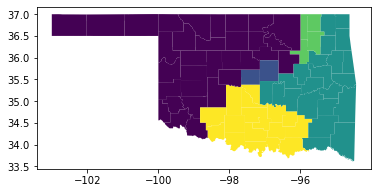

In [15]:
# Which district is each county assigned to?
assignment = [ -1 for u in G.nodes ]
    
# for each district j
for j in range(len(districts)):
    
    # for each node i in this district
    for i in districts[j]:
        
        # What is its GEOID?
        geoID = G.nodes[i]["GEOID10"]
        
        # Need to find this GEOID in the dataframe
        for u in G.nodes:
            if geoID == df['GEOID10'][u]: # Found it
                assignment[u] = j # Node u from the dataframe should be assigned to district j

# Now add the assignments to a column of the dataframe and map it
df['assignment'] = assignment
my_fig = df.plot(column='assignment').get_figure()